# Unidentified outputs

In an attempt to determine the reason that a DOI could not be found for a large number of records, this notebook analyses the differences between identified and unidentified records in some of the values originally provided by users.

In [1]:
import sqlitedict
import yaml
from sqlalchemy.orm import sessionmaker
import json
from synth.model.analysis import Output
from synth.model.rco_synthsys_live import NHMOutput, NHMOutputType, NHMPublicationStatu
from synth.utils import Config, Context
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import re
from textwrap import fill

Load connections to the databases and list of identified DOIs.

In [2]:
with open('../config.yml', 'r') as f:
    config = Config(**yaml.safe_load(f))

context = Context(config)
db = sessionmaker(bind=context.target_engine)()

cache = sqlitedict.SqliteDict('../synth/data/output_dois.db')

Create a pandas multiindex from the list of identified records.

In [3]:
found_ids = pd.MultiIndex.from_tuples([tuple(json.loads(k)) for k in cache.keys()], names=['db','record_id'])

Put all unprocessed records into a pandas dataframe and label them as identified or unidentified.

In [4]:
db_tables = []

columns = [
    NHMOutput.Output_ID.label('record_id'),
    NHMOutputType.OutputType.label('output_type'),
    NHMOutput.Authors.label('authors'),
    NHMOutput.Year.label('year'),
    NHMOutput.Title.label('title'),
    NHMOutput.Publisher.label('publisher'),
    NHMOutput.URL.label('URL'),
    NHMPublicationStatu.PublicationStatus.label('publication_status'),
    NHMOutput.Volume.label('volume'),
    NHMOutput.Pages.label('pages'),
    NHMOutput.Conference.label('conference'),
    NHMOutput.Degree.label('degree'),
    NHMOutput.Institute.label('institute'),
    NHMOutput.TrainingDetail.label('training_detail'),
    NHMOutput.UpdatedDate.label('updated_date'),
]


for ix, engine in enumerate(context.source_engines):
    db_session = sessionmaker(bind=engine)()
    q = db_session.query(*columns).outerjoin(
        NHMOutputType, NHMOutput.OutputType_ID == NHMOutputType.OutputType_ID).outerjoin(
        NHMPublicationStatu, NHMOutput.PublicationStatus_ID == NHMPublicationStatu.PublicationStatus_ID)
    df = pd.read_sql_query(q.selectable, engine)
    df['db'] = [ix + 1] * len(df)
    df = df.set_index(['db', 'record_id'])
    db_tables.append(df)
    
output_df = pd.concat(db_tables)

found = pd.DataFrame([True] * len(cache), columns=['identified'], index=found_ids)

output_df = output_df.join(found, how='left')
output_df.identified = output_df.identified.fillna(False)

output_df

output_type  \
db record_id                      
1  1              Peer Reviewed   
   2          Non Peer Reviewed   
   3              Peer Reviewed   
   4              Peer Reviewed   
   5              Peer Reviewed   
...                         ...   
4  6742           Peer Reviewed   
   6743           Peer Reviewed   
   6744           Peer Reviewed   
   6745           Peer Reviewed   
   6746           Peer Reviewed   

                                                        authors    year  \
db record_id                                                              
1  1          <span style="FONT-SIZE: 10pt; FONT-FAMILY: Ver...  2007.0   
   2          <font face="Arial"><strong>Janko, K.,</strong>...  2005.0   
   3          <strong>Janko,K.</strong>, <font color="#ff000...  2007.0   
   4          <strong>Janko,K.,</strong>&nbsp;<font color="#...  2007.0   
   5          Patocka, J. and&nbsp;<strong>Turcani</strong>,...  2007.0   
...                                                         ...     ...   
4  6742                                                    None     NaN   
   6743       <p>\r\n\t<span style="font-family: Arial, sans...  2019.0   
   6744       <p>\r\n\tOriane Loiseau, Anna Weigand, Sarah N...  2020.0   
   6745       <p>\r\n\tRodrigo C&aacute;mara-Leret, ... <str...  2020.0   
   6746                                                    None     NaN   

                                                          title  \
db record_id                                                      
1  1          Molecular phylogeny within true bugs (Hemipter...   
   2          Gene-flow solid frozen - the roles of intrinsi...   
   3          Age and rate of speciation in the adaptive rad...   
   4          Glacial advances during the Pleistocene influe...   
   5          Contribution to the Pupae of the Western Palea...   
...                                                         ...   
4  6742                                                    None   
   6743       New species of scaly tree ferns (Cyatheaceae) ...   
   6744       Slowly but surely: gradual diversification and...   
   6745         New Guinea has the world’s richest island flora   
   6746                                                    None   

                                                      publisher  \
db record_id                                                      
1  1          4th European Hemiptera Congress, Ivrea, Italy ...   
   2                                     Conference proceedings   
   3                                                       None   
   4                                   BMC Evolutionary Biology   
   5                                                       None   
...                                                         ...   
4  6742                                                    None   
   6743                                            Kew Bulletin   
   6744                                        Annals of Botany   
   6745                                                  Nature   
   6746                                                    None   

                                                    URL publication_status  \
db record_id                                                                 
1  1                        website: www.ehc4.unito.it/          Published   
   2                                               None          Published   
   3                                               None     In Preparation   
   4                                               None          Published   
   5                                               None     In Preparation   
...                                                 ...                ...   
4  6742                                            None               None   
   6743       https://doi.org/10.1007/s12225-019-9823-4          Published   
   6744              https://doi.org/10.1093/aob/mcz145         

## Missing values

Transform the values to simply 'missing' (False) or 'present' (True), then calculate the percentage of each as a propertion of the total number of records of that type (i.e. identified or unidentified).

In [5]:
has_value = output_df.notna()
has_value.identified = output_df.identified.copy()

has_value = has_value.melt(id_vars=['identified'])
has_value['count'] = [0] * len(has_value)
has_value = has_value.groupby(['identified', 'variable', 'value']).count()
has_value['count'] = (has_value['count'] / has_value.sum(axis=0, level=[0,1])['count']) * 100
has_value.reset_index(inplace=True)

has_value

,identified,variable,value,count
0,False,URL,False,90.430357
1,False,URL,True,9.569643
2,False,authors,False,31.574289
3,False,authors,True,68.425711
4,False,conference,False,87.686691
5,False,conference,True,12.313309
6,False,degree,False,95.386658
7,False,degree,True,4.613342
8,False,institute,False,95.353468
9,False,institute,True,4.646532


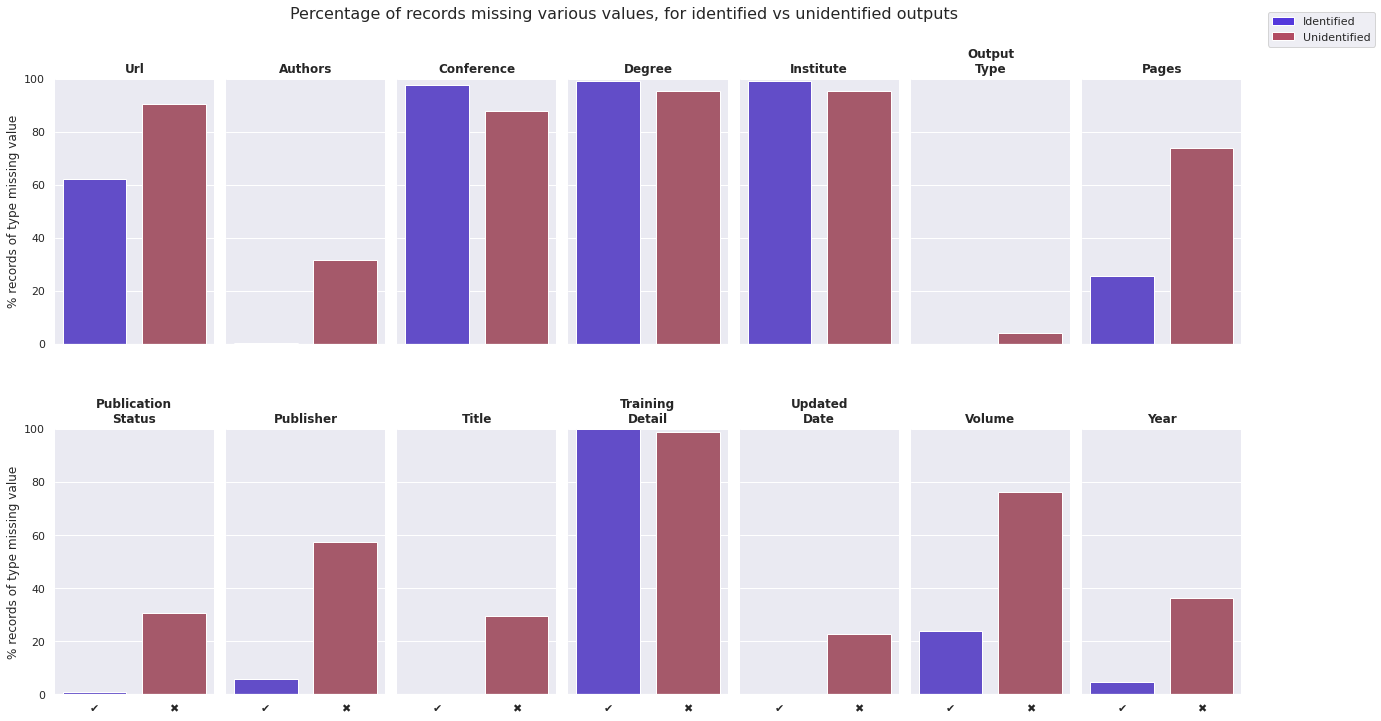

In [6]:
sns.set_theme(style='darkgrid')
palette = ['#5438DC', '#B24C63']

grid = sns.catplot(data=has_value[~has_value.value], 
                   x='identified', y='count', kind='bar', col='variable',
                   col_wrap=7, aspect=0.5, order=[True, False], palette=palette)

grid.set(ylim=(0, 100))
grid.set_axis_labels('', '% records of type missing value')
grid.set_xticklabels(['✔', '✖'])
grid.despine(left=True)

for variable, ax in grid.axes_dict.items():
    variable_title = '\n'.join([w.capitalize() for w in variable.split('_')])
    ax.set_title(variable_title, fontweight='bold')
    
legend_elements = [Patch(label='Identified', facecolor=palette[0]),
                   Patch(label='Unidentified', facecolor=palette[-1]),]
    
grid.fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1))
grid.fig.suptitle('Percentage of records missing various values, for identified vs unidentified outputs', fontsize=16, y=1)
grid.fig.tight_layout(w_pad=1, h_pad=4)

## Specific values

For most of the variables, looking at individual values is not going to be particularly insightful without further transformation and grouping (e.g. by looking for keywords). This is either due to lack of data validation or explanation on the input form (e.g. the _Publisher_ value was specified as either the publishing company name or the name of the publication, with no automated way to tell the difference), or because the data are necessarily unique (e.g. _Title_ has some repeats, but overall most values are only used once).

However, some variables had controlled values (_Output Type_, _Publication Status_) or values that were (mostly) limited by their nature (_Year_).

These few variables are isolated and plotted below. As above, these graphs show the proportion of records of that type (i.e. identified or unidentified) that have a particular value. Missing values are _not_ included.

NB: _Year_ was not actually a controlled field, so there are a number of unlikely values that are probably typos in the data. These have been left in, so that it can be seen if there is a correlation between 'unusual' values and inability to identify a DOI.

In [7]:
specific_values = output_df.copy()

specific_values = specific_values.melt(id_vars=['identified']).replace([
        'n/a', '-', 'N/A', 'NA', '\r\n', '\n', '\r'
    ])
specific_values['count'] = [0] * len(specific_values)
specific_values = specific_values.groupby(['identified', 'variable', 'value']).count()
specific_values['count'] = (specific_values['count'] / specific_values.sum(axis=0, level=[0,1])['count']) * 100
specific_values.reset_index(inplace=True)

graph_df = specific_values[specific_values.variable.isin(['output_type', 'publication_status'])].sort_values(['variable', 'count'])

graph_df

,identified,variable,value,count
29619,True,output_type,Training,0.185242
29615,True,output_type,"Database, CD or DVD",0.277864
29618,True,output_type,Thesis,0.586601
29614,True,output_type,Book/Monograph,2.130287
29616,True,output_type,Non Peer Reviewed,3.334362
7340,False,output_type,Training,3.895503
7336,False,output_type,"Database, CD or DVD",4.346318
7335,False,output_type,Book/Monograph,6.554156
7339,False,output_type,Thesis,6.935614
7337,False,output_type,Non Peer Reviewed,19.188533


Plot the controlled values (_Output Type_ and _Publication Status_).

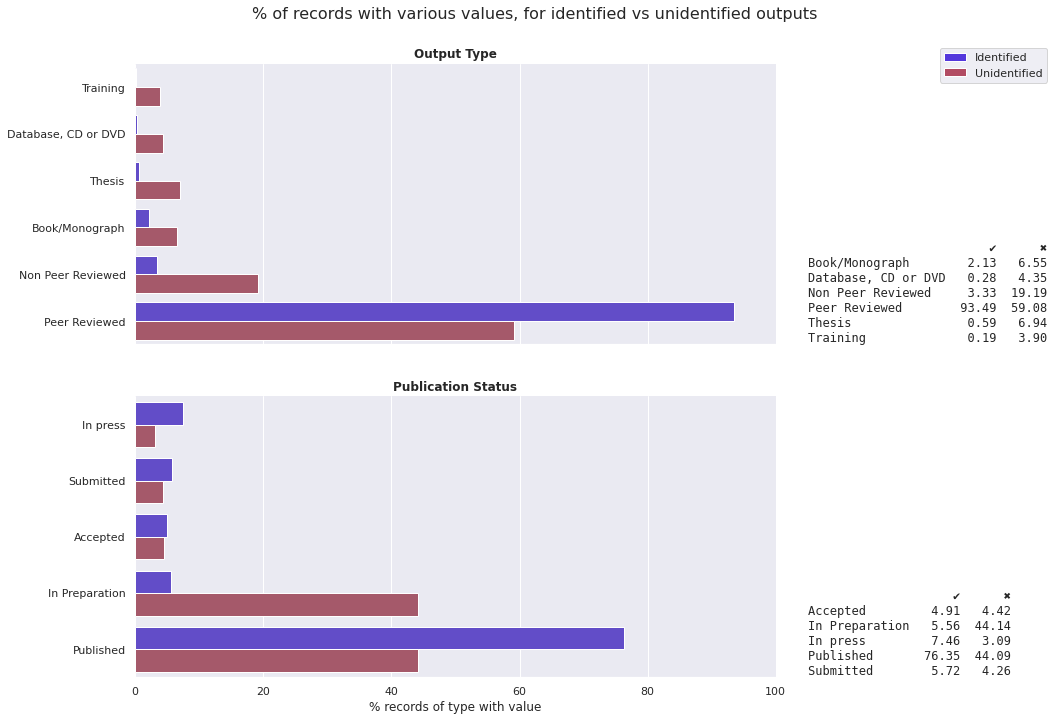

In [8]:
grid = sns.catplot(data=graph_df, 
                   x='count', y='value', hue='identified', kind='bar', col='variable', orient='h',
                   col_wrap=1, aspect=3, palette=palette, sharex=True, sharey=False, hue_order=[True, False], legend=False)

grid.set(xlim=(0, 100))
grid.set_axis_labels('% records of type with value', '')
grid.despine(left=True)

for variable, ax in grid.axes_dict.items():
    variable_title = ' '.join([w.capitalize() for w in variable.split('_')])
    ax.set_title(variable_title, fontweight='bold')
    
    display_stats = graph_df[graph_df.variable==variable].drop('variable', axis=1).round(2)
    display_stats.identified = display_stats.identified.replace(True, '✔').replace(False, '✖')
    display_stats = display_stats.pivot(index='value', columns='identified').droplevel(0, axis=1)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(1.05, 0, display_stats.to_string(col_space=5, index_names=False), transform=ax.transAxes,
            verticalalignment='bottom', bbox=props, fontdict={'size': 12, 'family': 'monospace'})

legend_elements = [Patch(label='Identified', facecolor=palette[0]),
                   Patch(label='Unidentified', facecolor=palette[-1]),]
    
grid.fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
grid.fig.suptitle('% of records with various values, for identified vs unidentified outputs', fontsize=16, y=1)
grid.fig.tight_layout(h_pad=3)

plt.show()

Plot _Year_ separately because it has significantly more potential values. The incorrect values may also be of more interest than the correct values, so different types of chart may be more useful.

In [9]:
year_df = output_df.copy()

year_df = year_df.melt(id_vars=['identified']).replace([
        'n/a', '-', 'N/A', 'NA', '\r\n', '\n', '\r'
    ])
year_df = year_df[year_df.variable == 'year'].dropna().drop('variable', axis=1)
year_df.value = year_df.value.astype(int)
year_df.columns = ['identified', 'year']
year_df.identified = year_df.identified.replace(True, 'Identified').replace(False, 'Unidentified')
year_df

,identified,year
24560,Unidentified,2007
24561,Unidentified,2005
24562,Unidentified,2007
24563,Identified,2007
24564,Unidentified,2007
...,...,...
36833,Identified,2020
36834,Unidentified,2020
36836,Identified,2019
36837,Identified,2020


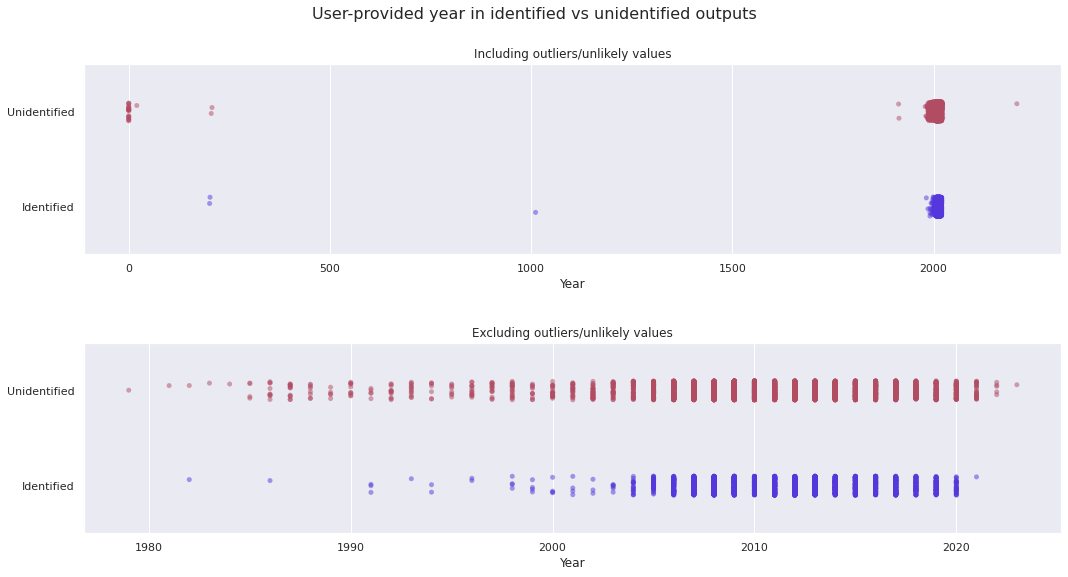

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(15,8))

sns.stripplot(data=year_df, x='year', y='identified', hue='identified', palette=palette, alpha=0.5, orient='h', hue_order=['Identified', 'Unidentified'], ax=axes[0])
axes[0].set_title('Including outliers/unlikely values')

sns.stripplot(data=year_df[(year_df.year > 1960) & (year_df.year < 2030)], x='year', y='identified', hue='identified', palette=palette, alpha=0.5, orient='h', hue_order=['Identified', 'Unidentified'], ax=axes[1])
axes[1].set_title('Excluding outliers/unlikely values')

for ax in axes:
    ax.legend().remove()
    ax.set_ylabel('')
    ax.set_xlabel('Year')
    

fig.suptitle('User-provided year in identified vs unidentified outputs', fontsize=16, y=1)
fig.tight_layout(h_pad=3)